# Creating a training dataset by applying a rule-based model to a set of texts

In [41]:
# default libraries
from datetime import datetime, time
import json
import os
import random
import re
import subprocess

# installed libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import confusion_matrix
import spacy
from spacy import displacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy.tokens import DocBin
from spacy.training import offsets_to_biluo_tags
from tqdm import tqdm
import warnings
import xmltodict

# local libraries
%reload_ext autoreload
%autoreload 2
import datahelper as dt

### Creating labeled vocabulary in json format

To create a rule-based NER model, text files consiting of all possible variations of 

In [2]:
# getting all the file names from data_txt folder
dir_path = f"{os.getcwd()}\\data_txt"
txt_files = [f for f in os.listdir(dir_path) if f.endswith(".txt")]

for file in tqdm(txt_files):
    dt.upgrade_data(f"data_txt/{file}")   # adding upper and lower case
    dt.delete_dublicates(f"data_txt/{file}")  # deleting duplicate lines
    with open (f"data_txt/{file}", "r", encoding="utf-8") as f:
        names = []
        for line in f.readlines():
            if line.strip() != '':
                names.append(line.strip()) # storing all the lines in an array
        names = list(set(names)) # making sure there no duplicate lines
    dt.save_data(f"data_json/{file[:-4]}.json", names)  # saving all the vocabulary to the .json file

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.41it/s]


In [3]:
labels = {"anxiety":"ANXIETY DISORDERS", 
          'bipolar':'BIPOLAR DISORDERS', 
          'depressive':"DEPRESSIVE DISORDERS", 
          'dissociative': "DISSOCIATIVE DISORDERS", 
          'drugs': "PSYCHEDELIC DRUGS", 
          'eating':"EATING DISORDERS", 
          'neurocog':"NEURO-COGNITIVE DISORDERS",
          'neurodev':"NEURO-DEVELOPMENTAL DISORDERS", 
          'nonsubstance':"NON-SUBSTANCE RELATED DISORDERS", 
          'ocd':"OBSESSIVE-COMPULSIVE AND RELATED DISORDERS", 
          'other':"OTHER DISORDERS", 
          'paraphilias':"PARAPHILIAS",  
          'personality':"PERSONALITY DISORDERS", 
          'schizophrenia':"SCHIZOPHRENIA SPECTRUM AND OTHER PSYCHOTIC DISORDERS", 
          'sexual':"SEXUAL DYSFUNCTIONS", 
          'sleep':"SLEEP-WAKE DISORDERS", 
          'somatic':"SOMATIC SYMPTOM RELATED DISORDERS", 
          'substance':"SUBSTANCE-RELATED DISORDERS", 
          'trauma':"TRAUMA AND STRESS RELATED DISORDERS",
          'elimination':"ELIMINATION DISORDERS",
          'disruptive':"DISRUPTIVE IMPULSE-CONTROL, AND CONDUCT DISORDERS",
          'symptoms':'SYMPTOMS'}

In [4]:
patterns = []
for file in tqdm(txt_files):
    patterns = dt.create_training_data(patterns, f"data_json/{file[:-4]}.json", labels[file[:-4]])
dt.generate_rules(patterns)

100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1128.71it/s]


### Testing on a test sample

Before using the model to create annotations, it was tested on a test sample in order to see how well can it catch necessary entities.

In [5]:
test="""After a decades-long pause, psychedelics are again being intensely investigated for treating a wide range of 
        neuropsychiatric ailments including depression, anxiety, addiction, post-traumatic stress disorder, anorexia, 
        and chronic pain syndromes. The classic serotonergic psychedelics psilocybin and lysergic acid diethylamide and 
        nonclassic psychedelics 3,4-methylenedioxymethamphetamine and ketamine are increasingly appreciated as neuroplastogens 
        given their potential to fundamentally alter mood and behavior well beyond the time window of measurable exposure. 
        Imaging studies with psychedelics are also helping advance our understanding of neural networks and connectomics. 
        This resurgence in psychedelic science and psychedelic-assisted therapy has potential significance for the fields of 
        neurosurgery and neuro-oncology and their diverse and challenging patients, many of whom continue to have mental health 
        issues and poor quality of life despite receiving state-of-the-art care. In this study, we review recent and ongoing 
        clinical trials, the set and setting model of psychedelic-assisted therapy, potential risks and adverse events, proposed 
        mechanisms of action, and provide a perspective on how the safe and evidence-based use of psychedelics could potentially 
        benefit many patients, including those with brain tumors, pain syndromes, ruminative disorders, stroke, SAH, TBI, and 
        movement disorders. By leveraging psychedelics' neuroplastic potential to rehabilitate the mind and brain, novel 
        treatments may be possible for many of these patient populations, in some instances working synergistically with current 
        treatments and in some using subpsychedelic doses that do not require mind-altering effects for efficacy. This review aims 
        to encourage broader multidisciplinary collaboration across the neurosciences to explore and help realize the transdiagnostic 
        healing potential of psychedelics."""
test = re.sub("[\n ]+", " ", test)

In [6]:
nlp = spacy.load("annotation_ner")
doc = nlp(test)

options = dt.pretty_colors()  # set colors for the labels
spacy.displacy.render(doc, style="ent", jupyter=True, options=options) # display catched entities

### Geting more training samples from pubmed using entrez pubmed api

In [7]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"

PMIDs = []
stats = {}
queries = []

for year in range(1963,2024):
    queries.append(f'(psychedelic anxiety depression) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')


for query in tqdm(queries):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        nb += 1
        PMIDs.append(id)
    stats[query[40:44]] = nb
PMIDs = list(set(PMIDs))
len(PMIDs)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:47<00:00,  1.28it/s]


563

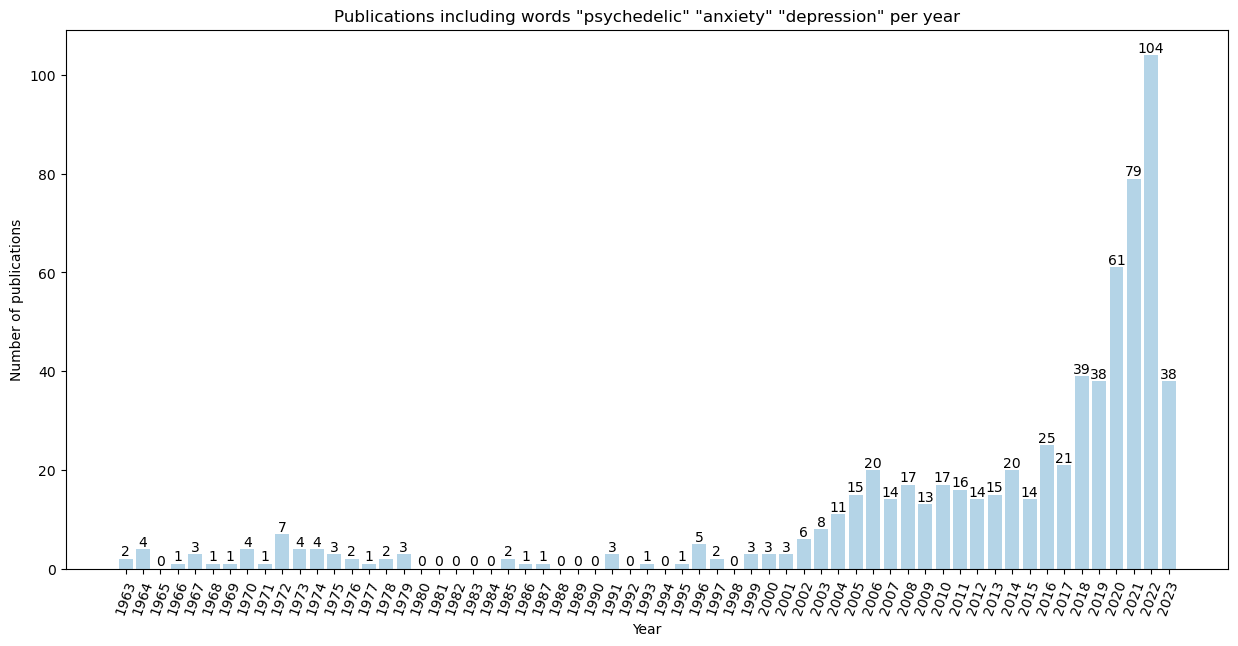

In [8]:
years = list(stats.keys())
values = list(stats.values())

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(years, values, color='#B4D4E7')

ax.set_xlabel('Year')
ax.set_ylabel('Number of publications')
ax.set_title('Publications including words "psychedelic" "anxiety" "depression" per year')

for i, value in enumerate(values):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=70)

plt.show()

I will devide 561 article into train and test set so that in train set there will be 2/3 * 561 = 374 texts and in test set the ret texts

In [9]:
abstracts = []

count = 0
for PMID in tqdm(PMIDs[:374]):
    count += 1
    if count % 10 == 0:
        time.sleep(1)
        
    summary = dt.get_summary(PMID)
    abstract = dt.get_abstract_from_summary(summary)
    
    abstracts.append(abstract)


  1%|▍                                                                                 | 2/374 [00:01<03:58,  1.56it/s]

No abstract


  1%|▉                                                                                 | 4/374 [00:02<04:13,  1.46it/s]

No abstract


  2%|█▎                                                                                | 6/374 [00:04<04:06,  1.50it/s]

No abstract


  7%|█████▋                                                                           | 26/374 [00:19<03:53,  1.49it/s]

No abstract


  8%|██████▍                                                                          | 30/374 [00:23<05:36,  1.02it/s]

No abstract


 10%|████████▏                                                                        | 38/374 [00:27<03:28,  1.61it/s]

No abstract


 17%|█████████████▍                                                                   | 62/374 [00:48<04:08,  1.25it/s]

No abstract


 17%|█████████████▋                                                                   | 63/374 [00:48<03:59,  1.30it/s]

No abstract


 22%|█████████████████▊                                                               | 82/374 [01:05<04:11,  1.16it/s]

No abstract


 25%|███████████████████▉                                                             | 92/374 [01:17<06:45,  1.44s/it]

No abstract


 36%|████████████████████████████▋                                                   | 134/374 [01:51<02:38,  1.51it/s]

No abstract


 38%|██████████████████████████████▌                                                 | 143/374 [01:58<03:15,  1.18it/s]

No abstract


 40%|███████████████████████████████▋                                                | 148/374 [02:03<03:07,  1.21it/s]

No abstract


 40%|███████████████████████████████▊                                                | 149/374 [02:03<02:44,  1.36it/s]

No abstract


 40%|████████████████████████████████▎                                               | 151/374 [02:06<03:33,  1.04it/s]

No abstract


 47%|█████████████████████████████████████▊                                          | 177/374 [02:25<02:10,  1.51it/s]

No abstract


 52%|█████████████████████████████████████████▋                                      | 195/374 [02:39<02:10,  1.37it/s]

No abstract


 59%|███████████████████████████████████████████████▍                                | 222/374 [03:01<02:00,  1.26it/s]

No abstract


 62%|█████████████████████████████████████████████████▊                              | 233/374 [03:09<01:43,  1.36it/s]

No abstract


 63%|██████████████████████████████████████████████████▎                             | 235/374 [03:10<01:30,  1.54it/s]

No abstract


 64%|███████████████████████████████████████████████████▎                            | 240/374 [03:14<02:04,  1.08it/s]

No abstract


 68%|██████████████████████████████████████████████████████▊                         | 256/374 [03:25<01:13,  1.60it/s]

No abstract


 72%|█████████████████████████████████████████████████████████▉                      | 271/374 [03:37<01:28,  1.17it/s]

No abstract


 76%|████████████████████████████████████████████████████████████▉                   | 285/374 [03:48<01:10,  1.26it/s]

No abstract


 78%|██████████████████████████████████████████████████████████████                  | 290/374 [03:53<01:32,  1.10s/it]

No abstract


 79%|███████████████████████████████████████████████████████████████▌                | 297/374 [03:59<01:11,  1.08it/s]

No abstract


 80%|███████████████████████████████████████████████████████████████▉                | 299/374 [04:00<01:03,  1.18it/s]

No abstract


 81%|████████████████████████████████████████████████████████████████▌               | 302/374 [04:04<01:04,  1.12it/s]

No abstract


 82%|█████████████████████████████████████████████████████████████████▏              | 305/374 [04:05<00:49,  1.39it/s]

No abstract


 83%|██████████████████████████████████████████████████████████████████▌             | 311/374 [04:11<00:56,  1.12it/s]

No abstract


 86%|████████████████████████████████████████████████████████████████████▍           | 320/374 [04:18<00:54,  1.02s/it]

No abstract


 89%|███████████████████████████████████████████████████████████████████████         | 332/374 [04:26<00:30,  1.38it/s]

No abstract


 92%|█████████████████████████████████████████████████████████████████████████▎      | 343/374 [04:34<00:22,  1.40it/s]

No abstract


 93%|██████████████████████████████████████████████████████████████████████████▍     | 348/374 [04:37<00:15,  1.70it/s]

No abstract


 93%|██████████████████████████████████████████████████████████████████████████▋     | 349/374 [04:38<00:14,  1.68it/s]

No abstract


 96%|████████████████████████████████████████████████████████████████████████████▌   | 358/374 [04:45<00:12,  1.28it/s]

No abstract


 99%|███████████████████████████████████████████████████████████████████████████████▌| 372/374 [04:57<00:01,  1.32it/s]

No abstract


100%|████████████████████████████████████████████████████████████████████████████████| 374/374 [04:59<00:00,  1.25it/s]


In [10]:
abstracts_valid = []

count = 0
for PMID in tqdm(PMIDs[374:]):
    count += 1
    if count % 10 == 0:
        time.sleep(1)
        
    summary = dt.get_summary(PMID)
    abstract = dt.get_abstract_from_summary(summary)
    
    abstracts_valid.append(abstract)

  1%|▍                                                                                 | 1/189 [00:00<01:47,  1.74it/s]

No abstract


  2%|█▎                                                                                | 3/189 [00:01<01:49,  1.70it/s]

No abstract


  2%|█▋                                                                                | 4/189 [00:02<01:50,  1.68it/s]

No abstract


 15%|████████████▍                                                                    | 29/189 [00:20<01:40,  1.59it/s]

No abstract


 18%|██████████████▌                                                                  | 34/189 [00:25<01:47,  1.45it/s]

No abstract


 19%|███████████████                                                                  | 35/189 [00:25<01:48,  1.42it/s]

No abstract


 19%|███████████████▍                                                                 | 36/189 [00:26<01:45,  1.44it/s]

No abstract


 24%|███████████████████▋                                                             | 46/189 [00:33<01:30,  1.58it/s]

No abstract


 34%|███████████████████████████▍                                                     | 64/189 [00:47<01:28,  1.41it/s]

No abstract


 36%|█████████████████████████████▏                                                   | 68/189 [00:49<01:17,  1.56it/s]

No abstract


 46%|█████████████████████████████████████▎                                           | 87/189 [01:04<01:10,  1.45it/s]

No abstract


 49%|███████████████████████████████████████▊                                         | 93/189 [01:09<01:08,  1.39it/s]

No abstract


 60%|████████████████████████████████████████████████▎                               | 114/189 [01:24<00:52,  1.43it/s]

No abstract


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [01:37<00:38,  1.45it/s]

No abstract


 72%|█████████████████████████████████████████████████████████▌                      | 136/189 [01:39<00:32,  1.63it/s]

No abstract


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [02:21<00:00,  1.34it/s]


In [28]:
nlp = spacy.load("annotation_ner")
TRAIN_DATA = {"classes": ["ANXIETY DISORDERS",
        "BIPOLAR DISORDERS",
        "DEPRESSIVE DISORDERS",
        "DISSOCIATIVE DISORDERS",
        "PSYCHEDELIC DRUGS",
        "EATING DISORDERS",
        "NEURO-COGNITIVE DISORDERS",
        "NEURO-DEVELOPMENTAL DISORDERS",
        "NON-SUBSTANCE RELATED DISORDERS",
        "OBSESSIVE-COMPULSIVE AND RELATED DISORDERS",
        "OTHER DISORDERS",
        "PARAPHILIAS",
        "PERSONALITY DISORDERS",
        "SCHIZOPHRENIA SPECTRUM AND OTHER PSYCHOTIC DISORDERS",
        "SEXUAL DYSFUNCTIONS",
        "SLEEP-WAKE DISORDERS",
        "SOMATIC SYMPTOM RELATED DISORDERS",
        "SUBSTANCE-RELATED DISORDERS",
        "TRAUMA AND STRESS RELATED DISORDERS",
        "ELIMINATION DISORDERS",
        "DISRUPTIVE IMPULSE-CONTROL, AND CONDUCT DISORDERS",
        "SYMPTOMS"], 
              "annotations": []}
for abstract in tqdm(abstracts):
    if abstract != None and abstract != '' and abstract != ' ' and abstract != '\n':
        #dt.test_model(nlp, abstract, 'test.txt')
        result = dt.test_model(nlp, abstract)
        if len(result) != 0:
            TRAIN_DATA["annotations"].append(result)
len(TRAIN_DATA)

100%|███████████████████████████████████████████████████████████████████████████████| 374/374 [00:01<00:00, 188.58it/s]


2

In [29]:
len(TRAIN_DATA["annotations"])

331

In [30]:
dt.save_data("data/train_data.json", TRAIN_DATA)

In [31]:
nlp = spacy.load("annotation_ner")
TEST_DATA = {"classes": ["ANXIETY DISORDERS",
        "BIPOLAR DISORDERS",
        "DEPRESSIVE DISORDERS",
        "DISSOCIATIVE DISORDERS",
        "PSYCHEDELIC DRUGS",
        "EATING DISORDERS",
        "NEURO-COGNITIVE DISORDERS",
        "NEURO-DEVELOPMENTAL DISORDERS",
        "NON-SUBSTANCE RELATED DISORDERS",
        "OBSESSIVE-COMPULSIVE AND RELATED DISORDERS",
        "OTHER DISORDERS",
        "PARAPHILIAS",
        "PERSONALITY DISORDERS",
        "SCHIZOPHRENIA SPECTRUM AND OTHER PSYCHOTIC DISORDERS",
        "SEXUAL DYSFUNCTIONS",
        "SLEEP-WAKE DISORDERS",
        "SOMATIC SYMPTOM RELATED DISORDERS",
        "SUBSTANCE-RELATED DISORDERS",
        "TRAUMA AND STRESS RELATED DISORDERS",
        "ELIMINATION DISORDERS",
        "DISRUPTIVE IMPULSE-CONTROL, AND CONDUCT DISORDERS",
        "SYMPTOMS"], 
              "annotations": []}
for abstract in tqdm(abstracts_valid):
    if abstract != None and abstract != '' and abstract != ' ' and abstract != '\n':
        result = dt.test_model(nlp, abstract)
        if len(result) != 0:
            TEST_DATA["annotations"].append(result)
len(TEST_DATA)

100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:01<00:00, 156.60it/s]


2

In [32]:
len(TEST_DATA["annotations"])

169

In [33]:
dt.save_data("data/test_data.json", TEST_DATA)

In [38]:
nlp = spacy.blank("en")
def v3_train(data):
    db = DocBin()  # Create a DocBin object
    annotations = tqdm(data["annotations"])
    for text, annot in annotations:
        doc = nlp.make_doc(text)  # Create doc object from text
        ents = []
        for start, end, label in annot["entities"]:  # Add character indexes
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents  # Label the text with the ents
        db.add(doc)
    return db

In [39]:
TRAIN_DATA = v3_train(TRAIN_DATA)
TRAIN_DATA.to_disk("data/train.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 331/331 [00:01<00:00, 188.31it/s]


In [40]:
TEST_DATA = v3_train(TEST_DATA)
TEST_DATA.to_disk("data/test.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:01<00:00, 147.69it/s]
